In [1]:
import os
import sys
import torch
from torch import Tensor
import torch.testing as torch_testing
from torch.utils.data import Subset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import numpy.testing as npt
from functools import reduce
import matplotlib.pyplot as plt
import os
import pickle
import cv2
from dataclasses import dataclass
import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import default_collate
import pprofile
from torchvision.models import resnet18, ResNet18_Weights
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

`convolutional layer`: main building block. Contains a set of learnable filters.

`forward pass`: each filter is slided over the spatial dimensions of the input volume

Hyperparameters:
- `F`: filter size
- `P`: padding amount
- `S`: stride/step
- `k`: number of filters: should match the depth of the input volume

<img src="https://lh6.googleusercontent.com/gZxwFH6mQ5tPjz6LzVbOaNeVuR1NC-BnuemIWO41qnn7r1PvP4qzwXRWC1OJgo2_PD08qaqJ2-VCF3q9laeK885IJwK-dHhpLDkvRZrx4vxrbLDTsKD2iZYM5SFRq4A6XTklk7_h" style="width:50vw;display:block;transform: translateX(10vw)"/>

Text(0.5, 1.0, 'Zero Padded - 2')

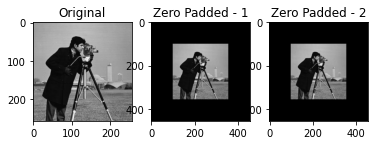

In [2]:
def zero_pad(X, pad):
    if len(X.shape) == 3:
        return np.pad(X, pad_width=[(0, 0),(pad,pad), (pad, pad)], mode='constant')
    else:
        return np.pad(X, pad_width=[(0, 0), (pad,pad), (pad, pad), (0,0)], mode='constant')

img = np.asarray(cv2.imread('cameraman.jpg', cv2.IMREAD_GRAYSCALE))
image_1, image_2 = zero_pad(np.array([img, img]), 100)

plt.subplot(1, 3, 1).imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 3, 2).imshow(image_1, cmap='gray')
plt.title('Zero Padded - 1')
plt.subplot(1, 3, 3).imshow(image_2, cmap='gray')
plt.title('Zero Padded - 2')

From shape ($H_i$, $W_i$, $D$) to shape ($H_o$, $W_o$, $k$), where:

\begin{equation}
W_o = \frac{W_i - F + 2P}{S} + 1
\end{equation}

\begin{equation}
H_o = \frac{H_i - F + 2P}{S} + 1
\end{equation}

In [3]:
def convolution(X, weight, bias, pad, stride):
  number_of_samples = X.shape[0]
  input_width = X.shape[2]
  input_height = X.shape[1]
  filter_size = weight.shape[0]

  output_width = int((input_width - filter_size + 2 * pad) / stride) + 1
  output_height = int((input_height - filter_size + 2 * pad) / stride) + 1
  output_channels = weight.shape[3]

  activation_map = np.zeros((number_of_samples, output_height, output_width, output_channels))

  X_padded = zero_pad(X, pad)

  for current_sample in range(number_of_samples):
    X_i = X_padded[current_sample, :, :, :]

    for current_height in range(output_height):
      top_left_y = current_height*stride
      bottom_right_y = current_height*stride + filter_size

      for current_width in range(output_width):
        top_left_x = current_width*stride
        bottom_right_x = current_width*stride + filter_size

        for current_channel in range(output_channels):
            roi = X_i[top_left_y:bottom_right_y, top_left_x:bottom_right_x, :]
            current_weight = weight[:, :, :, current_channel]
            current_bias = bias[:, :, :, current_channel]
            
            activation_map[current_sample,current_height,current_width,current_channel] = np.sum(roi * current_weight) + current_bias
        assert(activation_map.shape == (number_of_samples, output_height, output_width, output_channels))
  return activation_map
np.random.seed(10)
x = np.random.randn(100, 13, 21, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)

am = convolution(x, W, b, pad=1, stride=2)

npt.assert_equal(np.mean(am), -0.4284130223223714)
npt.assert_allclose(am[3,2,1], np.array([1.780819, -6.5181394, -4.3581524, -2.9115834, 1.8401672, -3.722643, -8.327618, -3.227787]))
print("am's mean =\n", np.mean(am))
print("am[1, 2, 3] =\n", am[3,2,1])


am's mean =
 -0.4284130223223714
am[1, 2, 3] =
 [ 1.78081902 -6.51813947 -4.35815226 -2.91158344  1.84016713 -3.72264278
 -8.32761753 -3.22778695]


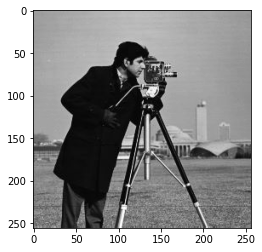

In [4]:
image = cv2.imread('cameraman.jpg', cv2.IMREAD_GRAYSCALE)
x = image.reshape(1, image.shape[0], image.shape[1], 1)
plt.imshow(image, cmap='gray')

`_Mean filter_`

Text(0.5, 1.0, 'mean filter 9x9')

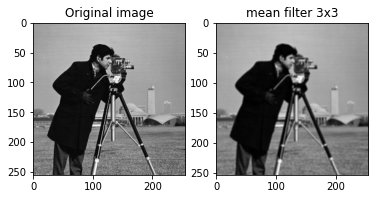

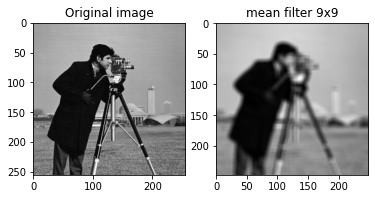

In [5]:
bias = np.asarray([0]).reshape((1, 1, 1, 1))
mean_filter_3 = np.ones(shape=(3, 3, 1, 1), dtype=np.float32)/9.0
mean_filter_9 = np.ones(shape=(9, 9, 1, 1), dtype=np.float32)/81.0

mean_3x3 = convolution(x, mean_filter_3, bias, pad=0, stride=1)
mean_9x9 = convolution(x, mean_filter_9, bias, pad=0, stride=1)

plt.figure(0)
plt.subplot(1, 2, 1).imshow(image, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2).imshow(mean_3x3[0, :, :, 0], cmap='gray')
plt.title('mean filter 3x3')
plt.figure(1)
plt.subplot(1, 2, 1).imshow(image, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2).imshow(mean_9x9[0, :, :, 0], cmap='gray')
plt.title('mean filter 9x9')

` _Gaussian filter_`

Text(0.5, 1.0, 'Gaussian filtered')

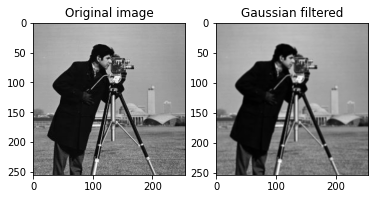

In [6]:
gaussian_filter = np.asarray([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=np.float32).reshape(3, 3, 1, 1)/16.0

gaussian_smoothed = convolution(x, gaussian_filter, bias, pad=0, stride=1)

plt.subplot(1, 2, 1).imshow(image, cmap='gray')
plt.title('Original image')
plt.subplot(1, 2, 2).imshow(gaussian_smoothed[0,:,:,0], cmap='gray')
plt.title('Gaussian filtered')

__Optional__: Now load a color image and apply the mean filtering and Gaussian filtering on this color image.
Not much changes at the call of the convolution operation, you just need to "play" with the convolutional kernels configurations.

Text(0.5, 1.0, '9x9+gaussian')

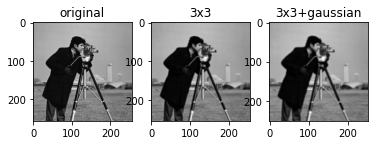

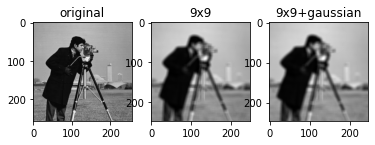

In [7]:
mean_filter_3 = np.ones(shape=(3, 3, 1, 1), dtype=np.float32)/9.0
mean_filter_9 = np.ones(shape=(9, 9, 1, 1), dtype=np.float32)/81.0
gaussian_filter = np.asarray([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=np.float32).reshape(3, 3, 1, 1)/16.0

mean_3x3 = convolution(x, mean_filter_3, bias, pad=0, stride=1)
mean_9x9 = convolution(x, mean_filter_9, bias, pad=0, stride=1)
gaussian_3x3 = convolution(mean_3x3, gaussian_filter, bias, pad=0, stride=1)
gaussian_9x9 = convolution(mean_9x9, gaussian_filter, bias, pad=0, stride=1)

plt.figure(0)
plt.subplot(1, 3, 1).imshow(image, cmap='gray')
plt.title('original')
plt.subplot(1, 3, 2).imshow(mean_3x3[0, :, :, 0], cmap='gray')
plt.title('3x3')
plt.subplot(1, 3, 3).imshow(gaussian_3x3[0, :, :, 0], cmap='gray')
plt.title('3x3+gaussian')
plt.figure(1)
plt.subplot(1, 3, 1).imshow(image, cmap='gray')
plt.title('original')
plt.subplot(1, 3, 2).imshow(mean_9x9[0, :, :, 0], cmap='gray')
plt.title('9x9')
plt.subplot(1, 3, 3).imshow(gaussian_9x9[0, :, :, 0], cmap='gray')
plt.title('9x9+gaussian')

`high pass filters`: used to highlight the high frequency information in an image (edges, abrupt changes in intensities).

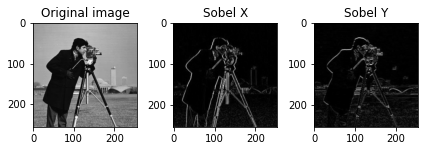

In [8]:
sobel_X_filter = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_X_filter = sobel_X_filter.reshape(3, 3, 1, 1)
sobel_Y_filter = sobel_X_filter.T.reshape(3, 3, 1, 1)

sobel_x = convolution(x, sobel_X_filter, bias, 0, 1)
sobel_y = convolution(x, sobel_Y_filter, bias, 0, 1)

plt.subplot(1, 3, 1).imshow(image, cmap='gray')
plt.title('Original image')
plt.subplot(1, 3, 2).imshow(np.abs(sobel_x[0,:,:,0])/np.abs(np.max(sobel_x[0,:,:,0]))*255, cmap='gray')
plt.title('Sobel X')
plt.subplot(1, 3, 3).imshow(np.abs(sobel_y[0,:,:,0])/np.abs(np.max(sobel_y[0,:,:,0]))*255, cmap='gray')
plt.title('Sobel Y')
plt.tight_layout()

`1` Design, implement, train a simple network **from scratch**.

`Get one with the data` -> Analyze your input images

torch.utils.data.Dataset -> Stores the actual information about the dataset

torch.utils.data.DataLoader -> Wraps an iterable around the dataset

In [9]:
tensor_transform = transforms.ToTensor()
normalize_lighting_transform = transforms.Normalize((0.5,), (0.5,))
resize_transform = transforms.Resize((128, 128))
transformation = transforms.Compose([tensor_transform, normalize_lighting_transform, resize_transform])

dataset = torchvision.datasets.OxfordIIITPet(root='./data', download=True, transform=transformation)
class RamDataset(torch.utils.data.Dataset): # Performance improvement, should be used only with small datasets
    def __init__(self, dataset: torch.utils.data.Dataset):
        data_loader = DataLoader(dataset, batch_size=len(dataset))
        self._classes = dataset.classes
        input, labels = next(iter(data_loader))
        self._input = input
        self._labels = labels
    def __getitem__(self, index):
        return self._input[index].to(device), self._labels[index].to(device)
    def __len__(self):
        return self._input.shape[0]
    @property
    def classes(self):
        return self._classes

dataset = RamDataset(dataset)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of samples in the dataset:  3680
Number of classes in the dataset:  37
Classes:  ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']
Shape of the first image:  tensor([[[-0.7212, -0.7264, -0.7093,  ...,  0.9809,  0.9610,  0.9515],
         [-0.7090, -0.6969, -0.7726,  ...,  1.0000,  0.9922,  0.9920],
         [-0.7210, -0.7445, -0.7247,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.9730, -0.8314, -0.9770,  ..., -0.5391, -0.5569, -0.5992],
      

Text(0.5, 1.0, 'Image class: Yorkshire Terrier')

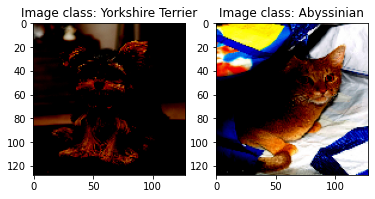

In [10]:
print("Number of samples in the dataset: ", len(dataset))
print("Number of classes in the dataset: ", len(dataset.classes))
print("Classes: ", dataset.classes)
print("Shape of the first image: ", dataset[0][0])
print("Shape of the last image: ", dataset[-1][0].shape)
first_image = dataset[0][0].cpu().numpy().transpose(1, 2, 0)
last_image = dataset[-1][0].cpu().numpy().transpose(1, 2, 0)
plt.subplot(1, 2, 2).imshow(first_image)
plt.title(f"Image class: {dataset.classes[dataset[0][1]]}")
plt.subplot(1, 2, 1).imshow(last_image)
plt.title(f"Image class: {dataset.classes[dataset[-1][1]]}")

Conclussions:

- The images vary in shape and lighting. They are stored in RGB format, but the color channels are the first in the tensors.

Transformation applied to all images: resized to 128x128, normalized image lighting, and permuted to normal RGB format

`Define the model`

In [11]:
learning_rate = 1e-2
weight_decay = 1e-4
batch_size = 50
number_of_epochs = 10

In [12]:
# https://www.researchgate.net/figure/The-proposed-CNN-architecture-images-input-128-128_tbl1_339234028
# https://www.kaggle.com/code/androbomb/using-cnn-to-classify-images-w-pytorch
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.drop = nn.Dropout2d(p=0.2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc = nn.Linear(in_features=32*32*24, out_features=len(dataset.classes))
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x)))  
        x = F.dropout(self.drop(x), training=self.training)
        x = x.view(-1, 32 * 32 * 24)
        x = self.fc(x)
        return torch.log_softmax(x, dim=1)

model = ConvolutionalNeuralNetwork().to(device)
loss_function = nn.CrossEntropyLoss()

`Training setup`

In [13]:
validation_size = 0.1
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=validation_size)
training_dataset, validation_dataset  = Subset(dataset, train_idx), Subset(dataset, val_idx)

training_loader, validation_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device)), DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, generator=torch.Generator(device=device))

`Train the model`

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epochs: 100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


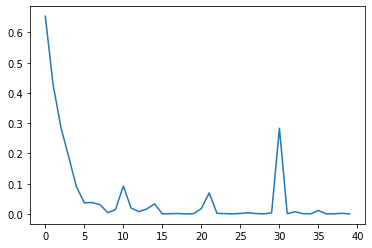

In [14]:
# profiler = pprofile.Profile() # For stats
# with profiler:

# loss_values = []
# model = ConvolutionalNeuralNetwork()
loss_values = torch.load("loss_values.torch")
model = torch.load("model.torch")

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 1e-2)
epochs = tqdm.tqdm(range(number_of_epochs), desc="Epochs")
for _ in epochs:
    running_loss = 0.0
    for images, labels in training_loader:
        outputs = model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss =+ loss.detach().item() * images.size(0)
    loss_values.append(running_loss/len(training_loader))
    scheduler.step()
torch.save(model, "model.torch")
torch.save(loss_values, "loss_values.torch")
plt.plot(loss_values)
# profiler.print_stats()

`Test the results`

In [15]:
model = torch.load("model.torch")
with torch.no_grad():
    correct_validation = 0
    total_validation = 0
    total_training = 0
    correct_training = 0
    for images, labels in validation_loader:
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels).sum().item()

    for images, labels in training_loader:
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
accuracy_validation = correct_validation / total_validation
accuracy_training = correct_training / total_training
print(f"Accuracy of the model on the {len(validation_dataset)} validation images: {accuracy_validation}")
print(f"Accuracy of the model on the {len(training_dataset)} training images: {accuracy_training}")

Accuracy of the model on the 368 validation images: 0.8777173913043478
Accuracy of the model on the 3312 training images: 0.9918478260869565


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


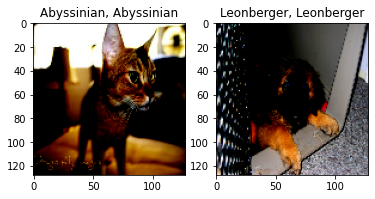

In [16]:
with torch.no_grad():
    for images, labels in training_loader:
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        random_index = np.random.randint(0, len(images)-1)
        first_image = images[random_index].cpu().numpy().transpose(1, 2, 0)
        last_image = images[random_index+1].cpu().numpy().transpose(1, 2, 0)
        
        plt.subplot(1, 2, 2).imshow(first_image)
        plt.title(f"{dataset.classes[predicted[random_index]]}, {dataset.classes[labels[random_index]]}")
        plt.subplot(1, 2, 1).imshow(last_image)
        plt.title(f"{dataset.classes[predicted[random_index+1]]}, {dataset.classes[labels[random_index+1]]}")
        break

`2` **transfer learning** to fine-tune an already trained model on your dataset.

In [17]:
pretrained_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
number_features = pretrained_model.fc.in_features

pretrained_model.fc = nn.Linear(number_features, len(dataset.classes))
pretrained_model.to(device)

In [20]:
loss_values = []
# loss_values = torch.load("pretrained_model.torch")
# pretrained_model = torch.load("loss_values_pretrained.torch")
optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
epochs = tqdm.tqdm(range(number_of_epochs), desc="Epochs")
for _ in epochs:
    running_loss = 0.0
    for images, labels in training_loader:
        outputs = pretrained_model(images)
        loss = loss_function(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss =+ loss.detach().item() * images.size(0)
    loss_values.append(running_loss/len(training_loader))
    scheduler.step()
torch.save(pretrained_model, "pretrained_model.torch")
torch.save(loss_values, "loss_values_pretrained.torch")
plt.plot(loss_values)

Epochs:  30%|███       | 3/10 [00:19<00:46,  6.61s/it]

In [19]:
pretrained_model = torch.load("pretrained_model.torch")
with torch.no_grad():
    correct_validation = 0
    total_validation = 0
    total_training = 0
    correct_training = 0
    for images, labels in validation_loader:
        outputs = pretrained_model(images)
        predicted = torch.argmax(outputs, dim=1)
        total_validation += labels.size(0)
        correct_validation += (predicted == labels).sum().item()

    for images, labels in training_loader:
        outputs = pretrained_model(images)
        predicted = torch.argmax(outputs, dim=1)
        total_training += labels.size(0)
        correct_training += (predicted == labels).sum().item()
accuracy_validation = correct_validation / total_validation
accuracy_training = correct_training / total_training
print(f"Accuracy of the pretrained_model on the {len(validation_dataset)} validation images: {accuracy_validation}")
print(f"Accuracy of the pretrained_model on the {len(training_dataset)} training images: {accuracy_training}")

Accuracy of the model on the 368 validation images: 0.8614130434782609
Accuracy of the model on the 3312 training images: 0.9921497584541062
